In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
import re

#setup
results = pd.read_pickle('testrun.pkl')
# results = pd.read_pickle('../simulation_engine/results/binaryIV/06_06/12/results.pkl')
binaryIV = ContinuousIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs


             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
    ATE_zaffalonbounds          0.00            14.65          0.4810      0.7035
ATE_entropybounds-0.10          0.00             7.55          0.5953      0.7013
       ATE_causaloptim          1.75             4.43          0.7152      0.7936
         ATE_autobound          1.20             2.63          0.7748      0.8214
ATE_entropybounds-0.20          0.00             4.20          0.7770      0.8284
ATE_entropybounds-0.80          0.00             3.20          0.9935      1.0257
         ATE_2SLS-0.95          0.40             3.77          1.0706      1.1091
         ATE_2SLS-0.98          0.40             1.66          1.1715      1.1885
         ATE_2SLS-0.99          0.40             1.05          1.2354      1.2465
           ATE_nonpara          0.00             0.00          1.6576      1.6576


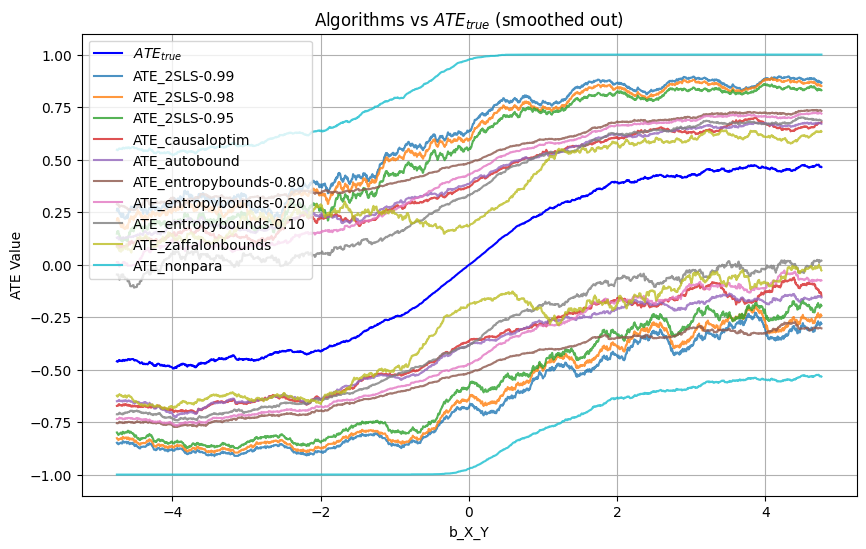

In [3]:
#ATE Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'ATE')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', ATE_algs, 100)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
           PNS_nonpara          0.00            27.55          0.1915      0.4142
    PNS_zaffalonbounds          0.00             1.50          0.3918      0.4009
       PNS_causaloptim          4.50            11.47          0.4106      0.5017
         PNS_autobound          1.20             1.47          0.4279      0.4431
PNS_entropybounds-0.10          0.00             0.25          0.5024      0.5036
PNS_entropybounds-0.20          0.00             0.10          0.5771      0.5775
PNS_entropybounds-0.80          0.00             0.10          0.7126      0.7129


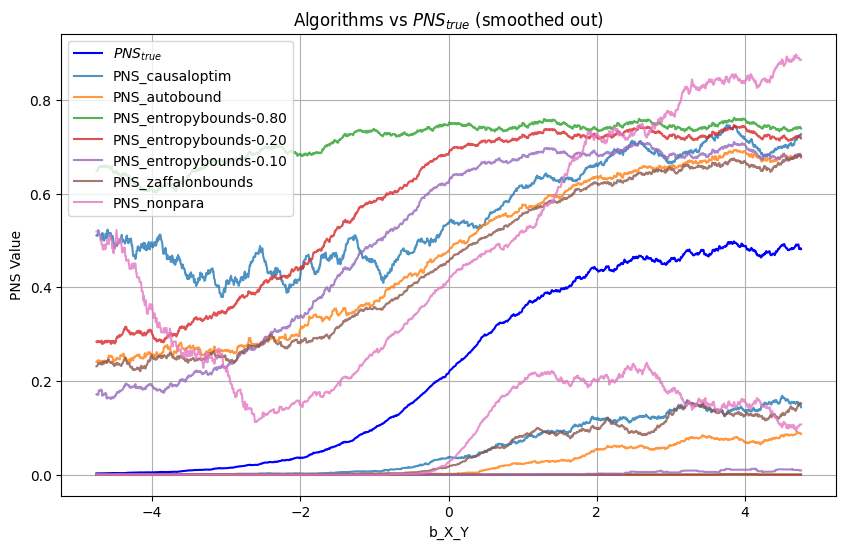

In [5]:
#PNS Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', PNS_algs, 100)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


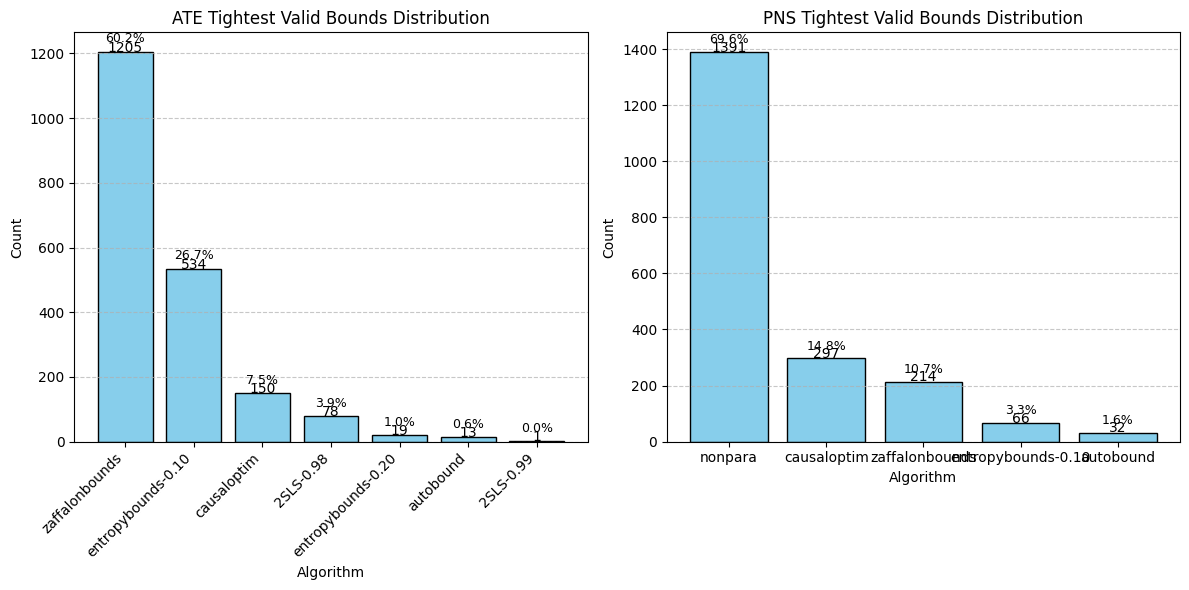

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
